In [34]:
from functools import reduce
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import utils

In [14]:
C_ELEGANS_TAXID = 6239

# df = pd.read_csv("./data/synergyage_database.csv").iloc[:, :-1].copy()
df = utils.get_synergyage_subset_with_biogrid_gene_names()
df.head(1)

,Unnamed: 0,Pubmed ID,Temperature,Diet,Details,Wild type lifespan (days),Gene 1,Intervention on gene 1,Gene 1 single mutant lifespan (days),"Gene(s) 2(,3)",...,"Double (triple) mutant (genes 1,2,(3)) lifespan (days)",Phenotype description,Organism,genes,genes_str,num_genes,FC,LOGFC,PERCENT_CHANGE,LIFESPAN_CLASS
2086,2086,19416129,20,NaN,Survival analyses began from hatching and were...,16.3,atm-1,gk186,19.5,frh-1,...,26.2,NaN,6239,"('atm-1', 'frh-1')",atm-1;frh-1,2,1.607362,0.684695,0.607362,PRO


In [15]:
df_celegans = df.loc[df['Organism'] == C_ELEGANS_TAXID]
df_celegans.shape

(2098, 22)

In [16]:
def clean_spaces_list_str(alist) -> list:
    """Remove white space, check if `,` and further split."""
    alist_augmented = []
    for elem in alist:
        if "," in elem:
            alist_augmented += elem.split(",")
        else:
            alist_augmented.append(elem)
        
    alist_cleaned = []
    for elem in alist_augmented:
        if elem[0] == " ":
            alist_cleaned.append(elem[1:])
        elif elem[-1] == " ":
            alist_cleaned.append(elem[:-1])
        else:
            alist_cleaned.append(elem)
    return alist_cleaned


INTERVENTION_GENES_1_COL = "Gene 1"
INTERVENTION_GENES_2_COL = "Gene(s) 2(,3)"

intervention_genes = []
intervention_genes_str = []
for i, row in df_celegans.iterrows():
    genes_1 = row[INTERVENTION_GENES_1_COL].split(";")
    genes_1 = clean_spaces_list_str(genes_1)
            
    genes_2 = row[INTERVENTION_GENES_2_COL].split(";")
    genes_2 = clean_spaces_list_str(genes_2)
    
    sorted_l = sorted([*genes_1, *genes_2])
    intervention_genes.append(tuple(sorted_l))
    intervention_genes_str.append(";".join(sorted_l))

df_celegans.loc[:, "genes"] = intervention_genes
df_celegans.loc[:, "genes_str"] = intervention_genes_str
df_celegans.loc[:, "num_genes"] = list(map(len, intervention_genes))

/home/eugen/miniconda3/envs/gnn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


<AxesSubplot:title={'center':'Number of genes intervened upon.'}, ylabel='Frequency'>

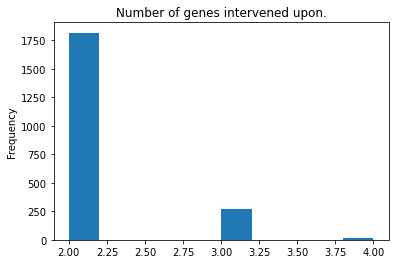

In [17]:
df_celegans["num_genes"].plot.hist(title="Number of genes intervened upon.")

In [18]:
genes = reduce(lambda s1, s2: s1.union(s2), intervention_genes, set([]))

<AxesSubplot:title={'center':'log2( # replicated combinations )'}, ylabel='Frequency'>

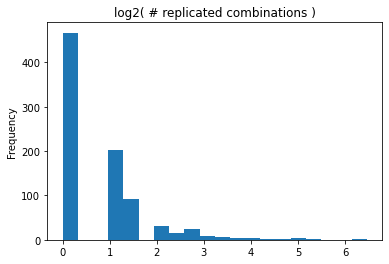

In [19]:
# need remove duplicated interventions
df_celegans["genes"].value_counts().transform(np.log2).plot.hist(title="log2( # replicated combinations )", bins=20)
# plt.plot(df_celegans["genes"].value_counts().values)

In [20]:
BASELINE_LS_COL = "Wild type lifespan (days)"
EFFECT_LS_COL = "Double (triple) mutant (genes 1,2,(3)) lifespan (days)"

df_celegans.loc[df_celegans[BASELINE_LS_COL].isna(), BASELINE_LS_COL] = df_celegans[BASELINE_LS_COL].dropna().mean()
assert df_celegans[BASELINE_LS_COL].isna().sum() == 0 and df_celegans[EFFECT_LS_COL].isna().sum() == 0
df_celegans.loc[:, "FC"] = df_celegans[EFFECT_LS_COL] / df_celegans[BASELINE_LS_COL]
df_celegans.loc[:, "LOGFC"] = np.log2(df_celegans["FC"])
df_celegans.loc[:, "PERCENT_CHANGE"] = (df_celegans[EFFECT_LS_COL] - df_celegans[BASELINE_LS_COL]) / df_celegans[BASELINE_LS_COL]

<AxesSubplot:title={'center':'log2(FC) distribution across all combinatorial interventions'}, ylabel='Frequency'>

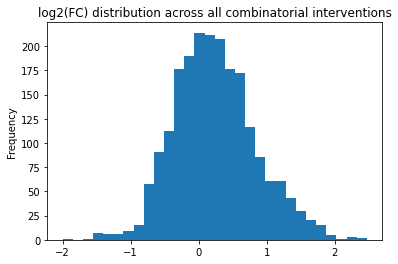

In [21]:
df_celegans["LOGFC"].plot.hist(title="log2(FC) distribution across all combinatorial interventions", bins=30)

In [22]:
(abs(df_celegans["LOGFC"]) > 0.5).sum()

853

In [23]:
LOGFC_CUTOFF = 0.5

conditions = [
    ( abs(df_celegans["LOGFC"]) <= 0.2 ),
    ( df_celegans["LOGFC"] > 0.2 ),
    ( df_celegans["LOGFC"] < -0.2 ),
]
values = utils.INTERVENTION_CLASSES

df_celegans["LIFESPAN_CLASS"] = np.select(conditions, values)

# df_celegans.to_csv("./data/synergyage_database_augmented.tsv", sep="\t")

In [24]:
df_celegans.LIFESPAN_CLASS.value_counts()

PRO     1052
NS       550
ANTI     496
Name: LIFESPAN_CLASS, dtype: int64

In [31]:
genes = utils.get_synergyage_genes(df_celegans)
print(f"There are {len(genes)} unique genes in synergy age.")

There are 355 unique genes in synergy age.


2098

In [43]:
intervention_genes = df_celegans.genes.to_list()

intervention_graph = nx.Graph()
for genes in intervention_genes:
    
    # Add gene node
    for gene in genes:
        if gene not in intervention_graph.nodes:
            intervention_graph.add_node(gene)

    # Add edges
    for gene_1, gene_2 in itertools.combinations(genes, 2):
        if (gene_1, gene_2) not in intervention_graph.edges:
            intervention_graph.add_edges_from([(gene_1, gene_2)])
        if (gene_2, gene_1) not in intervention_graph.edges:
            intervention_graph.add_edges_from([(gene_2, gene_1)])

In [44]:
len(intervention_graph.edges)

912

In [52]:
cc = nx.k_edge_components(intervention_graph, k=1)  #2
len(list(cc))

1